In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import _tree

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("../data/bank_marketing_dataset.csv")

In [3]:
df = df.drop(['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','duration','campaign','previous','subscribed', 'pdays', 'default'], axis=1)

In [4]:
df["combined_education"] = df["education"].apply(lambda x: "basic" if x in set({"basic.4y", "basic.6y", "basic.9y"}) else x)
df["job"] = df["job"].apply(lambda x: "high" if x in set({"admin.", "technician", "management", "entrepreneur", "self-employed"}) else "low")

In [5]:
df.head()

age   job  marital    education housing loan    contact month day_of_week  \
0   56   low  married     basic.4y      no   no  telephone   may         mon   
1   57   low  married  high.school      no   no  telephone   may         mon   
2   37   low  married  high.school     yes   no  telephone   may         mon   
3   40  high  married     basic.6y      no   no  telephone   may         mon   
4   56   low  married  high.school      no  yes  telephone   may         mon   

      poutcome combined_education  
0  nonexistent              basic  
1  nonexistent        high.school  
2  nonexistent        high.school  
3  nonexistent              basic  
4  nonexistent        high.school

In [6]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df[["job", "marital", "combined_education", "contact", "month", "day_of_week", "housing", "loan"]]).toarray()
encoded_personal_info = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(["job", "marital", "combined_education", "contact", "month", "day_of_week", "housing", "loan"]))
encoded_personal_info = pd.concat([df, encoded_personal_info], axis=1)
encoded_personal_info = encoded_personal_info.drop(["job", "marital", "combined_education", "contact", "month", "day_of_week", "poutcome", "housing_unknown", "loan_unknown", "education"], axis=1)
encoded_personal_info.head()

age housing loan  job_high  job_low  marital_divorced  marital_married  \
0   56      no   no       0.0      1.0               0.0              1.0   
1   57      no   no       0.0      1.0               0.0              1.0   
2   37     yes   no       0.0      1.0               0.0              1.0   
3   40      no   no       1.0      0.0               0.0              1.0   
4   56      no  yes       0.0      1.0               0.0              1.0   

   marital_single  marital_unknown  combined_education_basic  ...  month_sep  \
0             0.0              0.0                       1.0  ...        0.0   
1             0.0              0.0                       0.0  ...        0.0   
2             0.0              0.0                       0.0  ...        0.0   
3             0.0              0.0                       1.0  ...        0.0   
4             0.0              0.0                       0.0  ...        0.0   

   day_of_week_fri  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0              0.0              1.0              0.0              0.0   
1              0.0              1.0              0.0              0.0   
2              0.0              1.0              0.0              0.0   
3              0.0              1.0              0.0              0.0   
4              0.0              1.0              0.0              0.0   

   day_of_week_wed  housing_no  housing_yes  loan_no  loan_yes  
0              0.0         1.0          0.0      1.0       0.0  
1              0.0         1.0          0.0      1.0       0.0  
2              0.0         0.0          1.0      1.0       0.0  
3              0.0         1.0          0.0      1.0       0.0  
4              0.0         1.0          0.0      0.0       1.0  

[5 rows x 36 columns]

In [7]:
housing_df = encoded_personal_info[encoded_personal_info.housing != "unknown"]
housing_train = housing_df.drop(["housing", "loan", "housing_yes", "housing_no"], axis=1)
housing_label = housing_df["housing"]
housing_train.head()

age  job_high  job_low  marital_divorced  marital_married  marital_single  \
0   56       0.0      1.0               0.0              1.0             0.0   
1   57       0.0      1.0               0.0              1.0             0.0   
2   37       0.0      1.0               0.0              1.0             0.0   
3   40       1.0      0.0               0.0              1.0             0.0   
4   56       0.0      1.0               0.0              1.0             0.0   

   marital_unknown  combined_education_basic  combined_education_high.school  \
0              0.0                       1.0                             0.0   
1              0.0                       0.0                             1.0   
2              0.0                       0.0                             1.0   
3              0.0                       1.0                             0.0   
4              0.0                       0.0                             1.0   

   combined_education_illiterate  ...  month_nov  month_oct  month_sep  \
0                            0.0  ...        0.0        0.0        0.0   
1                            0.0  ...        0.0        0.0        0.0   
2                            0.0  ...        0.0        0.0        0.0   
3                            0.0  ...        0.0        0.0        0.0   
4                            0.0  ...        0.0        0.0        0.0   

   day_of_week_fri  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0              0.0              1.0              0.0              0.0   
1              0.0              1.0              0.0              0.0   
2              0.0              1.0              0.0              0.0   
3              0.0              1.0              0.0              0.0   
4              0.0              1.0              0.0              0.0   

   day_of_week_wed  loan_no  loan_yes  
0              0.0      1.0       0.0  
1              0.0      1.0       0.0  
2              0.0      1.0       0.0  
3              0.0      1.0       0.0  
4              0.0      0.0       1.0  

[5 rows x 32 columns]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(housing_train, housing_label, test_size=0.3, random_state=1)

In [9]:
np.random.seed(seed=0)
dt = RandomForestClassifier(class_weight='balanced', criterion='gini', max_features='log2', min_samples_leaf=4, n_estimators=200, max_depth=10, min_samples_split=2)
dt_model = dt.fit(X_train,y_train)
housing_pred = dt_model.predict(X_test)
y_true_numeric = [1 if label == 'yes' else 0 for label in y_test]
y_pred_numeric = [1 if label == 'yes' else 0 for label in housing_pred]

precision = precision_score(y_true_numeric, y_pred_numeric)
recall = recall_score(y_true_numeric, y_pred_numeric)
f1 = f1_score(y_true_numeric, y_pred_numeric)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1_score: {f1:.2f}")
print('Decision Tree accuracy for training set: %f' % dt_model.score(X_train, y_train))
print('Decision Tree accuracy for test set: %f' % dt_model.score(X_test, y_test))

Precision: 0.57
Recall: 0.62
F1_score: 0.60
Decision Tree accuracy for training set: 0.603348
Decision Tree accuracy for test set: 0.548839


In [10]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

#print(feature_importances)
top_n = 18  
top_features = feature_importances.iloc[:top_n]['Feature'].tolist()

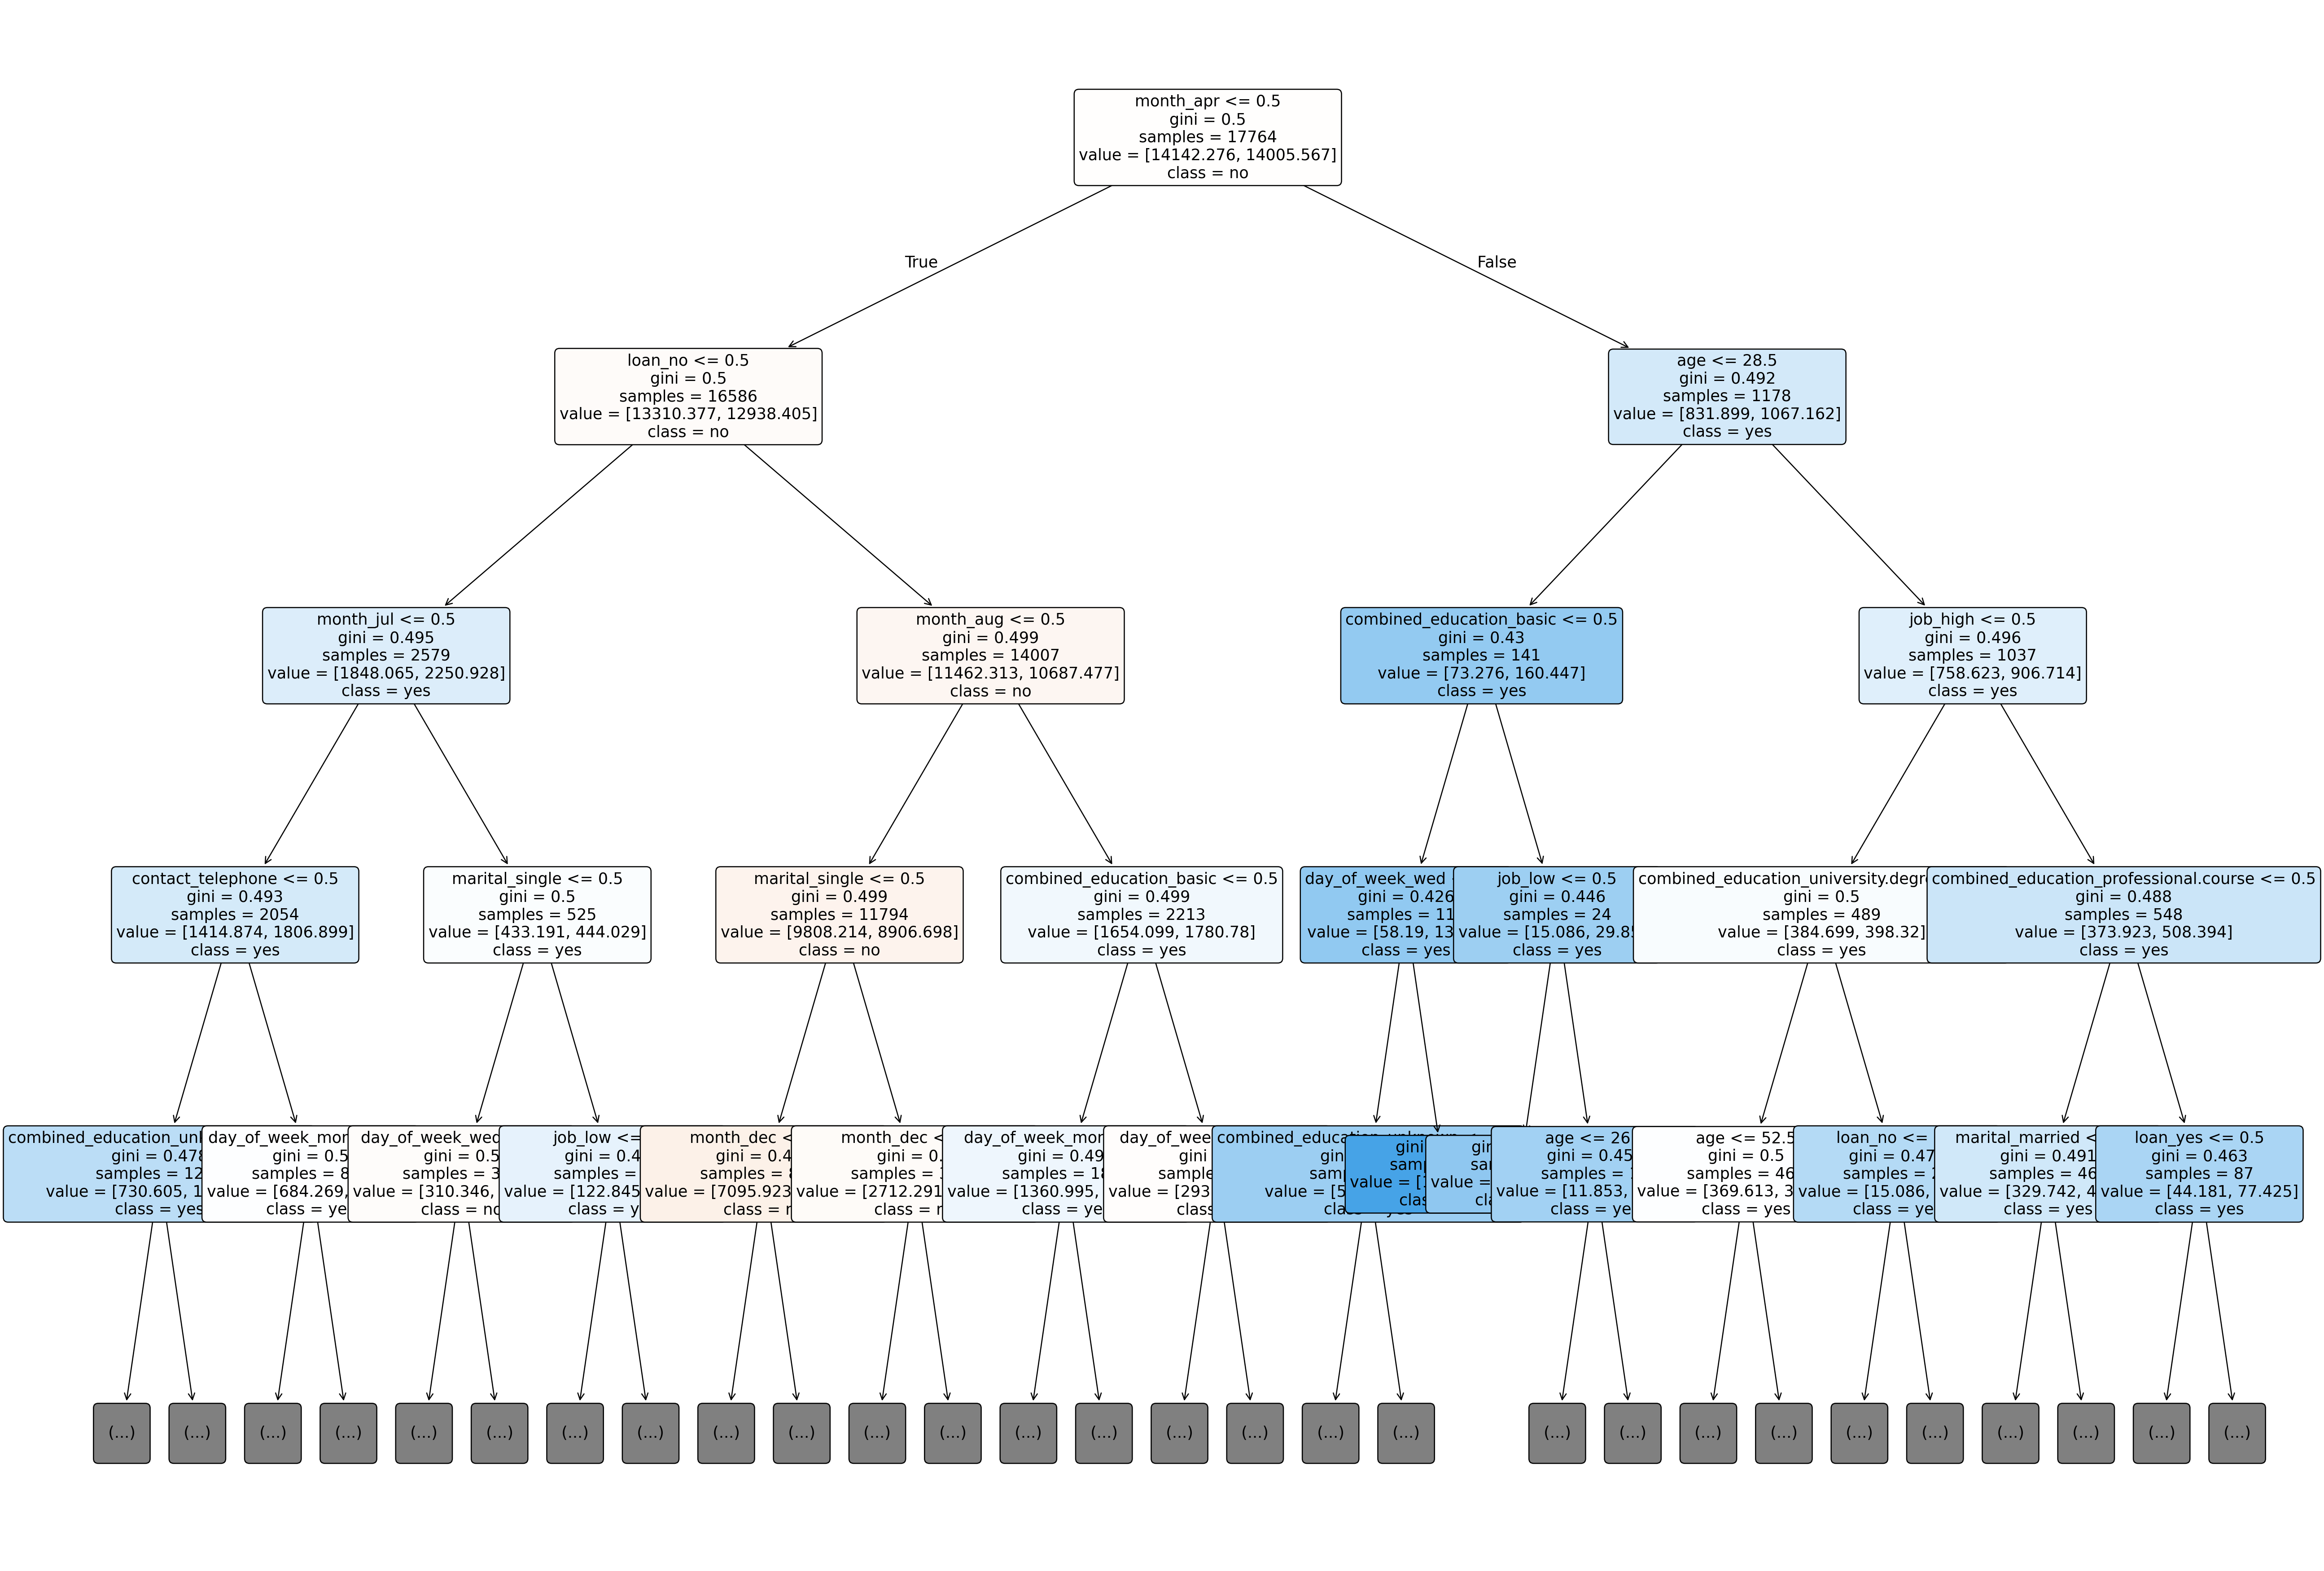

In [11]:
important_tree = dt_model.estimators_[0]

plt.figure(figsize=(35, 25), dpi=180)  
plot_tree(
    important_tree,
    feature_names=X_train.columns,
    class_names=[str(i) for i in np.unique(y_train)],
    filled=True,
    rounded=True,
    max_depth=4, 
    fontsize=14  
)
plt.show()


In [12]:
loan_df = encoded_personal_info[encoded_personal_info.loan != "unknown"]
loan_train = loan_df.drop(["housing", "loan", "loan_yes", "loan_no"], axis=1)
loan_label = loan_df["loan"]
loan_train.head()

age  job_high  job_low  marital_divorced  marital_married  marital_single  \
0   56       0.0      1.0               0.0              1.0             0.0   
1   57       0.0      1.0               0.0              1.0             0.0   
2   37       0.0      1.0               0.0              1.0             0.0   
3   40       1.0      0.0               0.0              1.0             0.0   
4   56       0.0      1.0               0.0              1.0             0.0   

   marital_unknown  combined_education_basic  combined_education_high.school  \
0              0.0                       1.0                             0.0   
1              0.0                       0.0                             1.0   
2              0.0                       0.0                             1.0   
3              0.0                       1.0                             0.0   
4              0.0                       0.0                             1.0   

   combined_education_illiterate  ...  month_nov  month_oct  month_sep  \
0                            0.0  ...        0.0        0.0        0.0   
1                            0.0  ...        0.0        0.0        0.0   
2                            0.0  ...        0.0        0.0        0.0   
3                            0.0  ...        0.0        0.0        0.0   
4                            0.0  ...        0.0        0.0        0.0   

   day_of_week_fri  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0              0.0              1.0              0.0              0.0   
1              0.0              1.0              0.0              0.0   
2              0.0              1.0              0.0              0.0   
3              0.0              1.0              0.0              0.0   
4              0.0              1.0              0.0              0.0   

   day_of_week_wed  housing_no  housing_yes  
0              0.0         1.0          0.0  
1              0.0         1.0          0.0  
2              0.0         0.0          1.0  
3              0.0         1.0          0.0  
4              0.0         1.0          0.0  

[5 rows x 32 columns]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(loan_train, loan_label, test_size=0.2, random_state=1)

In [14]:
np.random.seed(seed=0)
dt = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=300)
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
dt_model = dt.fit(X_train_resampled, y_train_resampled)
print('Decision Tree accuracy for training set: %f' % dt_model.score(X_train, y_train))
print('Decision Tree accuracy for test set: %f' % dt_model.score(X_test, y_test))

Decision Tree accuracy for training set: 0.871820
Decision Tree accuracy for test set: 0.780597


In [15]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

#print(feature_importances)
top_n = 18 
top_features = feature_importances.iloc[:top_n]['Feature'].tolist()

In [16]:
important_tree = dt_model.estimators_[0]

plt.figure(figsize=(50, 35), dpi=280)  
plot_tree(
    important_tree,
    feature_names=X_train.columns,
    class_names=[str(i) for i in np.unique(y_train)],
    filled=True,
    rounded=True,
    max_depth=4, 
    fontsize=14  
)
plt.show()